### Kaggle bootstrapping

In [3]:
# Kaggle COMPETITION bootstrapping
COMPETITION_NAME = 'nlp-getting-started'

!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [4]:
!ls {path}

models	sample_submission.csv  test.csv  train.csv


### Explore the data

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

In [7]:
df.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [8]:
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [9]:
df.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [10]:
df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

<AxesSubplot:>

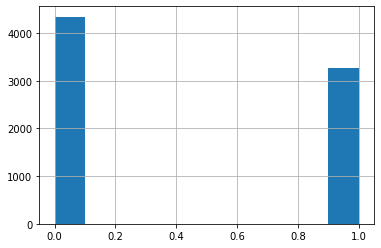

In [11]:
df.target.hist()

In [12]:
# sample non-disaster tweet
df[df.target == 0].text.values[0]

"What's up man?"

In [13]:
# sample disaster tweet
df[df.target == 1].text.values[1]

'Forest fire near La Ronge Sask. Canada'

### Preprocess the data

In [17]:
df['text_len'] = df.text.str.len()
df

,id,keyword,location,text,target,text_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,83
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,125
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,65
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,137


In [18]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len'], dtype='object')

In [19]:
def preprocess(df):
    df.keyword.fillna('none', inplace=True)
    df.location.fillna('unknown', inplace=True)
    df['rich_text'] = 'keyword: ' + df.keyword + '; location: ' + df.location +'; tweet: ' + df.text
    return df

In [20]:
df = preprocess(df)
df.head()

,id,keyword,location,text,target,text_len,rich_text
0,1,none,unknown,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69,keyword: none; location: unknown; tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,4,none,unknown,Forest fire near La Ronge Sask. Canada,1,38,keyword: none; location: unknown; tweet: Forest fire near La Ronge Sask. Canada
2,5,none,unknown,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133,keyword: none; location: unknown; tweet: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,6,none,unknown,"13,000 people receive #wildfires evacuation orders in California",1,65,"keyword: none; location: unknown; tweet: 13,000 people receive #wildfires evacuation orders in California"
4,7,none,unknown,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88,keyword: none; location: unknown; tweet: Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


In [21]:
df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len', 'rich_text'], dtype='object')

### Let's use transformers via blurr now!

In [22]:
!pip install -Uqq transformers

In [23]:
# gpu memory management
import gc, torch
!pip install -Uqq pynvml

def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [24]:
print(torch.cuda.list_gpu_processes())

GPU:0
no processes are running


In [25]:
!pip install -Uqq ohmeow-blurr

In [26]:
import os, warnings

import torch
from transformers import *
from transformers.utils import logging as hf_logging
from fastai.text.all import *

from blurr.text.data.all import *
from blurr.text.modeling.all import *

warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

os.environ["TOKENIZERS_PARALLELISM"] = "false"

/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [27]:
labels = df["target"].unique()
labels

array([1, 0])

In [28]:
n_labels = len(labels)
n_labels

2

In [29]:
model_cls = AutoModelForSequenceClassification

pretrained_model_name = "distilbert-base-uncased"

config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = n_labels

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
    pretrained_model_name,
    model_cls=model_cls, 
    config=config
)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [42]:
del learn
report_gpu()

GPU:0
process      36274 uses     8123.625 MB GPU memory


In [43]:
blocks = (
    TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), 
    CategoryBlock
)
dblock = DataBlock(
    blocks=blocks, 
    get_x=ColReader("rich_text"), 
    get_y=ColReader("target"), 
    splitter=RandomSplitter(valid_pct=0.2)
)

dls = dblock.dataloaders(df, bs=32)
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,keyword : mayhem ; location :?? made in the philippines?? ; tweet : _????? retweet???????????? follow all who rt???????????? followback???????????? gain with???????????? follow? @ ganseyman # rt _ 4 _ a _ mention # ty,0
1,keyword : aftershock ; location : switzerland ; tweet : 320 [ ir ] icemoon [ aftershock ] | http : / / t. co / m4jdzmgjow | @ djicemoon | # dubstep # trapmusic # dnb # edm # dance # icesu _ http : / / t. co / n0uhasfkbv,0


In [44]:
model = BaseModelWrapper(hf_model)

learn = Learner(
    dls,
    model,
    opt_func=partial(Adam, decouple_wd=True),
    loss_func=CrossEntropyLossFlat(),
    metrics=[accuracy, error_rate],
    cbs=[BaseModelCallback],
    splitter=blurr_splitter,
)

SuggestedLRs(minimum=0.0001737800776027143, steep=0.0003311311302240938, valley=0.0002290867705596611)

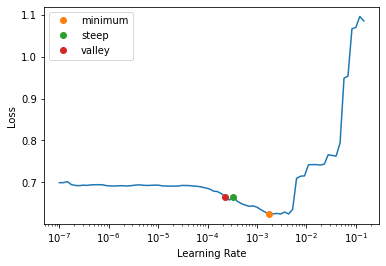

In [45]:
learn.lr_find(suggest_funcs=(minimum, steep, valley))

In [46]:
learn.freeze()

learn.fit_one_cycle(10, 5e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.491258,0.426407,0.814717,0.185283,00:56
1,0.439258,0.434308,0.805519,0.194481,00:56
2,0.406898,0.414591,0.814060,0.185940,00:56
3,0.390717,0.393354,0.833771,0.166229,00:58
4,0.346195,0.415955,0.831800,0.168200,00:56
5,0.339626,0.475309,0.809461,0.190539,00:56
6,0.341157,0.403361,0.827858,0.172142,00:56
7,0.296987,0.406380,0.832457,0.167543,00:56
8,0.288337,0.407224,0.832457,0.167543,00:56


KeyboardInterrupt: 

In [37]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.356933,0.400273,0.827201,0.172799,00:27


### predictions for test data

In [38]:
test_df = pd.read_csv(path/'test.csv')
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [42]:
test_df = preprocess(test_df)
test_df.head()

,id,keyword,location,text,rich_text
0,0,none,unknown,Just happened a terrible car crash,keyword: none; location: unknown; tweet: Just happened a terrible car crash
1,2,none,unknown,"Heard about #earthquake is different cities, stay safe everyone.","keyword: none; location: unknown; tweet: Heard about #earthquake is different cities, stay safe everyone."
2,3,none,unknown,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","keyword: none; location: unknown; tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,none,unknown,Apocalypse lighting. #Spokane #wildfires,keyword: none; location: unknown; tweet: Apocalypse lighting. #Spokane #wildfires
4,11,none,unknown,Typhoon Soudelor kills 28 in China and Taiwan,keyword: none; location: unknown; tweet: Typhoon Soudelor kills 28 in China and Taiwan


In [43]:
test_dl = dls.test_dl(test_df)
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [44]:
decoded.shape

torch.Size([3263])

In [45]:
decoded.float().mean() # tensor(0.3889)

tensor(0.3200)

### Submission

In [46]:
submission = pd.read_csv(path/'sample_submission.csv')
submission.shape

(3263, 2)

In [47]:
submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [48]:
submission.target = decoded
submission.head()

,id,target
0,0,0
1,2,1
2,3,0
3,9,1
4,11,1


In [49]:
test_df.head()

,id,keyword,location,text,rich_text
0,0,none,unknown,Just happened a terrible car crash,keyword: none; location: unknown; tweet: Just happened a terrible car crash
1,2,none,unknown,"Heard about #earthquake is different cities, stay safe everyone.","keyword: none; location: unknown; tweet: Heard about #earthquake is different cities, stay safe everyone."
2,3,none,unknown,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all","keyword: none; location: unknown; tweet: there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
3,9,none,unknown,Apocalypse lighting. #Spokane #wildfires,keyword: none; location: unknown; tweet: Apocalypse lighting. #Spokane #wildfires
4,11,none,unknown,Typhoon Soudelor kills 28 in China and Taiwan,keyword: none; location: unknown; tweet: Typhoon Soudelor kills 28 in China and Taiwan


### send submission to Kaggle!

In [50]:
# write submission csv
technique = '-distilbert-base-uncased'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    print('about to submit', sub_filename, 'to kaggle')
    input('continue?')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/nlp-getting-started--distilbert-base-uncased-sub.csv to kaggle


continue? y


100%|██████████| 22.2k/22.2k [00:00<00:00, 40.5kB/s]


Successfully submitted to Natural Language Processing with Disaster Tweets
